In [1]:
import dtt2hdf
import matplotlib.pyplot as plt
import numpy as np
items = dtt2hdf.read_diaggui('./data/SRM_TML_200722.xml')


c:\users\tec\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
items.results

Bunch(
    'COH' = {'K1:VIS-SRM_TM_TEST_L_EXC': DeepBunch(
         'BW' = 0.0117187,
         'FHz' = array([0.00000000e+00, 7.81311035e-03, 1.56262207e-02, ...,
                9.99921863e+01, 9.99999994e+01, 1.00007812e+02]),
         'averages' = 5,
         'avgtype' = 'Fixed',
         'channelA' = 'K1:VIS-SRM_TM_TEST_L_EXC',
         'channelB' = array(['K1:VIS-SRM_IM_DAMP_L_IN1', 'K1:VIS-SRM_IM_DAMP_T_IN1',
                'K1:VIS-SRM_IM_DAMP_V_IN1', 'K1:VIS-SRM_IM_DAMP_R_IN1',
                'K1:VIS-SRM_IM_DAMP_P_IN1', 'K1:VIS-SRM_IM_DAMP_Y_IN1',
                'K1:VIS-SRM_BF_DAMP_GAS_IN1', 'K1:VIS-SRM_F1_DAMP_GAS_IN1',
                'K1:VIS-SRM_F0_DAMP_GAS_IN1', 'K1:VIS-SRM_TM_OPLEV_LEN_DIAG',
                'K1:VIS-SRM_TM_OPLEV_PIT_DIAG', 'K1:VIS-SRM_TM_OPLEV_YAW_DIAG'],
               dtype='<U28'),
         'channelB_inv' = {'K1:VIS-SRM_IM_DAMP_L_IN1': 0,
          'K1:VIS-SRM_IM_DAMP_T_IN1': 1,
          'K1:VIS-SRM_IM_DAMP_V_IN1': 2,
          'K1:VIS-SRM_IM_DAMP_R_

In [43]:
items.results.PSD['K1:VIS-SRM_TM_TEST_L_EXC'].PSD[0]

array([123.427246, 293.78098 , 370.33636 , ...,  85.48593 , 134.84073 ,
       129.88141 ], dtype=float32)

In [182]:
f=items.results.CSD['K1:VIS-SRM_TM_TEST_L_EXC'].FHz
mask = 0.01<f
mask2 = f<10
mask=mask*mask2
# mask2 = f<10
f=f[mask]
L2P_CSD = items.results.CSD['K1:VIS-SRM_TM_TEST_L_EXC'].CSD[10]
L_exc_PSD = items.results.PSD['K1:VIS-SRM_TM_TEST_L_EXC'].PSD[0]
L2P = L2P_CSD/L_exc_PSD**2
L2P=L2P[mask]

In [116]:
mask2

array([ True,  True,  True, ..., False, False, False])

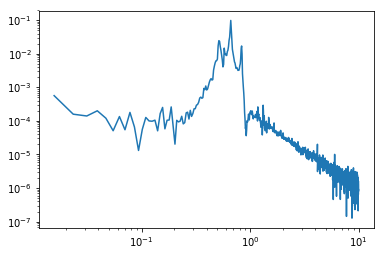

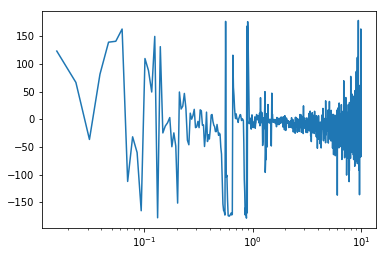

In [165]:
plt.loglog(f, abs(L2P))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
# plt.xlim(0.1,10)
# plt.ylim()

In [34]:
from control import *

In [66]:
def sso(fn, Q, unit = 'Hz'):
    if unit == 'Hz':
        fn = 2*np.pi*fn
    return(tf([fn**2],[1, fn/Q, fn**2]))

In [94]:
L2P_model = -1e-4*sso(0.52,100)/sso(0.3,5)*sso(0.65,1000)*sso(0.8,1000)/sso(0.9,1000)

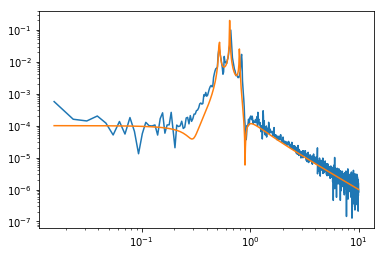

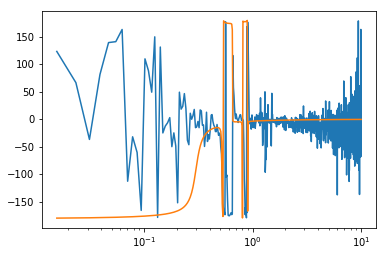

In [167]:
plt.loglog(f, abs(L2P))
plt.loglog(f, abs(L2P_model.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
plt.semilogx(f, np.angle(L2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [136]:
def cost(args, reference_model, f, data, weight=None):
    if weight is None:
        weight = np.ones_like(f)
    model_num = args[0:len(reference_model.num[0][0])]
    model_den = args[len(reference_model.num[0][0]):len(args)]
    model = tf(model_num, model_den)
    residue = sum(abs((model.horner(2*np.pi*f*1j)[0][0]-data)/abs(data))*weight)
    return(residue)

In [217]:
def cost_stable(args, f, data, weight):
    k=args[0]
    p1=args[1]
    p2=args[2]
    p3=args[3]
    z4=args[4]
    z5=args[5]
    q1=args[6]
    q2=args[7]
    q3=args[8]
    q4=args[9]
    q5=args[10]
    model = k*sso(p1,q1)/sso(z4,q4)*sso(p2,q2)*sso(p3,q3)/sso(z5,q5)
    residue = sum(abs((model.horner(2*np.pi*f*1j)[0][0]-data)/abs(data))*weight)
    return(residue)

In [137]:
cost(x0, L2P_model, f, L2P)

671.4854017059074

In [127]:
from scipy.optimize import minimize

In [123]:
x0=list(L2P_model.num[0][0])+list(L2P_model.den[0][0])

In [187]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0
res = minimize(cost, args=(L2P_model, f, L2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 90.605384
         Iterations: 5081
         Function evaluations: 7073


In [215]:
# L2P_model = -1e-4*sso(0.52,100)/sso(0.3,5)*sso(0.65,1000)*sso(0.8,1000)/sso(0.9,1000)
x0=[-1e-4, 0.52, 0.65, 0.8, 0.3, 0.9, 100, 5, 1000, 1000, 1000]

In [218]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0
res = minimize(cost_stable, args=(f, L2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 101.898483
         Iterations: 68036
         Function evaluations: 93755


In [188]:
res

 final_simplex: (array([[-5.03313959e-01, -2.95558895e-01, -1.70720681e+01,
        -8.97417920e+00, -1.33747992e+01,  1.06051415e+02,
         4.49402104e+00,  5.84436101e+03,  2.08573415e+02,
         9.98202227e+04,  2.50494601e+03,  5.27560897e+05],
       [-5.03313959e-01, -2.95558895e-01, -1.70720681e+01,
        -8.97417920e+00, -1.33747991e+01,  1.06051415e+02,
         4.49402104e+00,  5.84436101e+03,  2.08573415e+02,
         9.98202227e+04,  2.50494601e+03,  5.27560897e+05],
       [-5.03313959e-01, -2.95558895e-01, -1.70720681e+01,
        -8.97417919e+00, -1.33747990e+01,  1.06051415e+02,
         4.49402104e+00,  5.84436101e+03,  2.08573414e+02,
         9.98202227e+04,  2.50494601e+03,  5.27560897e+05],
       [-5.03313959e-01, -2.95558895e-01, -1.70720681e+01,
        -8.97417921e+00, -1.33747991e+01,  1.06051415e+02,
         4.49402104e+00,  5.84436100e+03,  2.08573415e+02,
         9.98202227e+04,  2.50494601e+03,  5.27560897e+05],
       [-5.03313958e-01, -2.9555889

In [189]:
args=res.x
fit_num = args[0:len(L2P_model.num[0][0])]
fit_den = args[len(L2P_model.num[0][0]):len(args)]
L2P_fit = tf(fit_num, fit_den)


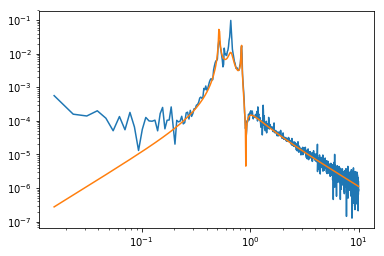

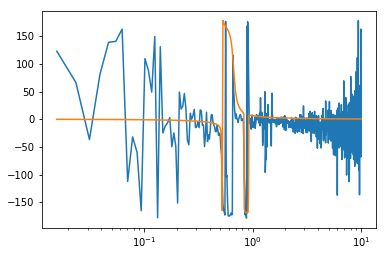

In [224]:
plt.loglog(f, abs(L2P))
# plt.loglog(f, abs(L2P_model.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(L2P_fit.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
# plt.semilogx(f, np.angle(L2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
plt.semilogx(f, np.angle(L2P_fit.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [225]:
res.x

array([-2.69734386e-17,  5.19027582e-01,  6.67085429e-01,  8.32750693e-01,
        1.54758465e-07,  9.14826476e-01,  1.21981457e+02,  1.08409579e+01,
        1.14235549e+03,  4.49991078e+02,  9.69495638e+02])

In [220]:
args=res.x
k=args[0]
p1=args[1]
p2=args[2]
p3=args[3]
z4=args[4]
z5=args[5]
q1=args[6]
q2=args[7]
q3=args[8]
q4=args[9]
q5=args[10]
L2P_fit = k*sso(p1,q1)/sso(z4,q4)*sso(p2,q2)*sso(p3,q3)/sso(z5,q5)

In [221]:
L2P_fit


                  -1.38e-13 s^4 - 8.18e-16 s^3 - 4.559e-12 s^2 - 9.85e-21 s - 4.31e-24
-------------------------------------------------------------------------------------------------------
3.124e-11 s^6 + 1.306e-11 s^5 + 1.737e-09 s^4 + 5.007e-10 s^3 + 2.997e-08 s^2 + 3.945e-09 s + 1.598e-07

In [222]:
L2P_fit.pole()

array([-0.00229015+5.23232642j, -0.00229015-5.23232642j,
       -0.19331416+4.18696103j, -0.19331416-4.18696103j,
       -0.01336739+3.26111908j, -0.01336739-3.26111908j])

In [223]:
L2P_fit.zero()

array([-2.96444050e-03+5.74802351e+00j, -2.96444050e-03-5.74802351e+00j,
       -1.08043933e-09+9.72375513e-07j, -1.08043933e-09-9.72375513e-07j])

In [185]:
L2P_fit.damp()

(array([5.2488262, 5.2488262, 4.2128287, 4.2128287, 3.2339319, 3.2339319]),
 array([ 0.00374147,  0.00374147,  0.01305851,  0.01305851, -0.01453781,
        -0.01453781]),
 array([-0.01963834+5.24878946j, -0.01963834-5.24878946j,
        -0.05501326+4.21246949j, -0.05501326-4.21246949j,
         0.04701428+3.23359014j,  0.04701428-3.23359014j]))

In [181]:
items_p2p = dtt2hdf.read_diaggui('./data/SRM_TMP_200722.xml')
f=items_p2p.results.CSD['K1:VIS-SRM_TM_TEST_P_EXC'].FHz
mask = 0.01<f
mask2 = f<10
mask=mask*mask2
# mask2 = f<10
f=f[mask]
P2P_CSD = items_p2p.results.CSD['K1:VIS-SRM_TM_TEST_P_EXC'].CSD[10]
P_exc_PSD = items_p2p.results.PSD['K1:VIS-SRM_TM_TEST_P_EXC'].PSD[0]
P2P = P2P_CSD/P_exc_PSD**2
P2P=P2P[mask]

In [198]:
P2P_model=0.1*sso(0.5,1000)/sso(0.51,1000)*sso(0.8,1000)

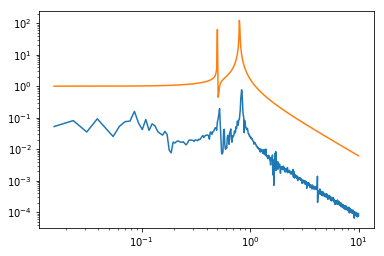

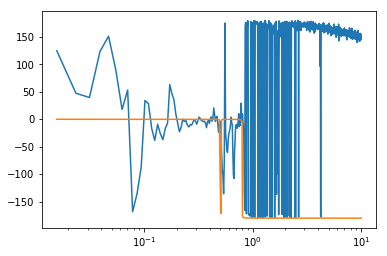

In [199]:
plt.loglog(f, abs(P2P))
plt.loglog(f, abs(P2P_model.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(P2P)*180/np.pi))
plt.semilogx(f, unwrap(np.angle(P2P_model.horner(2*np.pi*1j*f)[0][0]))*180/np.pi)
# plt.xlim(0.1,10)

In [200]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0
x0=list(P2P_model.num[0][0])+list(P2P_model.den[0][0])
res = minimize(cost, args=(P2P_model, f, P2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 90.673538
         Iterations: 2373
         Function evaluations: 3584


In [202]:
args=res.x
fit_num = args[0:len(P2P_model.num[0][0])]
fit_den = args[len(P2P_model.num[0][0]):len(args)]
P2P_fit = tf(fit_num, fit_den)

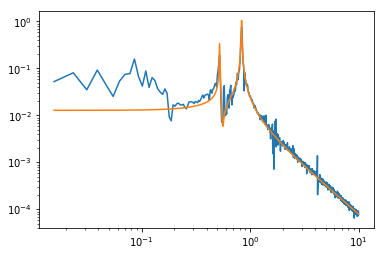

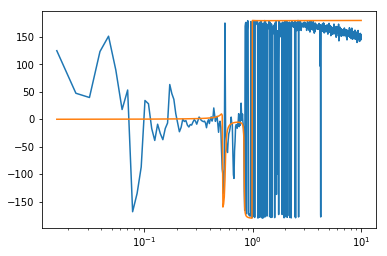

In [203]:
plt.loglog(f, abs(P2P))
# plt.loglog(f, abs(P2P_model.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(P2P_fit.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(P2P)*180/np.pi))
# plt.semilogx(f, np.angle(P2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
plt.semilogx(f, np.angle(P2P_fit.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [228]:
L2PonP2P=L2P_fit/P2P_fit
L2PonP2P.minreal()


-0.01412 s^8 - 0.0007883 s^7 - 1.008 s^6 - 0.03487 s^5 - 22.13 s^4 - 0.3018 s^3 - 139.7 s^2 - 3.02e-07 s - 1.321e-10
--------------------------------------------------------------------------------------------------------------------
        s^8 + 0.5334 s^7 + 67.95 s^6 + 27.59 s^5 + 1645 s^4 + 434.3 s^3 + 1.693e+04 s^2 + 2145 s + 6.294e+04

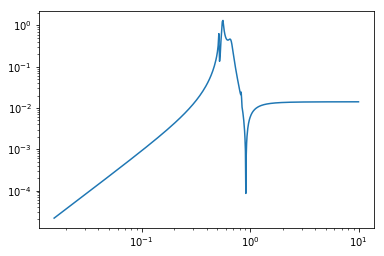

In [230]:
plt.loglog(f,abs(L2PonP2P.minreal().horner(2*np.pi*1j*f)[0][0]))